# Intro

First, I need to get acquainted with the information we have. Since this is a small tech challenge, the data should be fairly simple.

The task at hand is: Train one or more time-series forecasting models that predict sales_quantity per item per day and report on their quality.

## Remarks

Sales had repeated entries, we drop them.

We have a dataset of three items, tomatoes, tangerines and oninons, sold at retail store between 2021-04-03 and 2022-02-09.

Onions have an almost all year availability, since their sales look fairly similar through the year. Tomatoes and tangerines, on the other hand, have long periods of no availability, possibly due to their harvesting seasons. Furthermore, onions present a weekly seasonality with high sales on the weekends.

In [1]:
import pandas as pd
import numpy as np
import os
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

plt.rcParams["figure.figsize"] = (16, 4)


DATA_FOLDER = '/home/jeronimo/Desktop/Freshflow_techChallenge/FreshFlowChallenge/data/'


%matplotlib inline
%load_ext autoreload
%autoreload 2

In [26]:
dateparse = lambda x: pd.to_datetime(x, errors='coerce', format='%Y-%m-%d')

sales = pd.read_csv(os.path.join(DATA_FOLDER, 'data.csv'), parse_dates=['day'], date_parser=dateparse).drop('Unnamed: 0', axis=1)
print(sales.shape)
sales.head(20)

(1878, 8)


,day,item_number,item_name,purchase_price,suggested_retail_price,orders_quantity,sales_quantity,revenue
0,2022-02-09,80317483,ROMA TOMATEN ES I 500G SF,0.920000,1.490000,0.0,16.0,23.55
1,2022-02-09,80317483,ROMA TOMATEN ES I 500G SF,0.920000,1.490000,0.0,16.0,23.55
2,2022-02-09,80101923,SL MANDARINEN BEH.ES I 750G GS,2.050000,3.490000,0.0,3.0,10.47
3,2022-02-09,80101923,SL MANDARINEN BEH.ES I 750G GS,2.050000,3.490000,0.0,3.0,10.47
4,2022-02-09,80028349,UH ZWIEBELN DE-HE I 1KG GS,0.640000,0.990000,0.0,13.0,12.84
5,2022-02-09,80028349,UH ZWIEBELN DE-HE I 1KG GS,0.640000,0.990000,0.0,13.0,12.84
6,2022-02-08,80317483,ROMA TOMATEN ES I 500G SF,0.920000,1.490000,10.0,14.0,20.71
7,2022-02-08,80317483,ROMA TOMATEN ES I 500G SF,0.920000,1.490000,10.0,14.0,20.71
8,2022-02-08,80101923,SL MANDARINEN BEH.ES I 750G GS,2.050000,3.490000,0.0,3.0,9.89
9,2022-02-08,80101923,SL MANDARINEN BEH.ES I 750G GS,2.050000,3.490000,0.0,3.0,9.89


There seem to be repeated entries. Lets look further:

In [29]:
# this is exactly half of the entries!
sales.drop_duplicates().shape

(939, 8)

In [31]:
# look at some random slice of the data to double check the structure is repeated
sales[222:240]

,day,item_number,item_name,purchase_price,suggested_retail_price,orders_quantity,sales_quantity,revenue
222,2022-01-03,80317483,ROMA TOMATEN ES I 500G SF,0.960000,1.490000,20.0,10.0,14.90
223,2022-01-03,80317483,ROMA TOMATEN ES I 500G SF,0.960000,1.490000,20.0,10.0,14.90
224,2022-01-03,80101923,SL MANDARINEN BEH.ES I 750G GS,1.991321,3.216415,0.0,0.0,NaN
225,2022-01-03,80101923,SL MANDARINEN BEH.ES I 750G GS,1.991321,3.216415,0.0,0.0,NaN
226,2022-01-03,80028349,UH ZWIEBELN DE-HE I 1KG GS,0.630000,0.990000,0.0,23.0,22.68
227,2022-01-03,80028349,UH ZWIEBELN DE-HE I 1KG GS,0.630000,0.990000,0.0,23.0,22.68
228,2022-01-02,80317483,ROMA TOMATEN ES I 500G SF,0.978451,1.546338,0.0,0.0,NaN
229,2022-01-02,80317483,ROMA TOMATEN ES I 500G SF,0.978451,1.546338,0.0,0.0,NaN
230,2022-01-02,80101923,SL MANDARINEN BEH.ES I 750G GS,1.991321,3.216415,0.0,0.0,NaN
231,2022-01-02,80101923,SL MANDARINEN BEH.ES I 750G GS,1.991321,3.216415,0.0,0.0,NaN


I think it is fair to assume that the sales are repeated, so I will drop duplicates.

In [34]:
dateparse = lambda x: pd.to_datetime(x, errors='coerce', format='%Y-%m-%d')

sales = pd.read_csv(os.path.join(DATA_FOLDER, 'data.csv'), parse_dates=['day'], date_parser=dateparse).drop('Unnamed: 0', axis=1)
sales.drop_duplicates(inplace=True)

print(sales.shape)
sales.head()

(939, 8)


,day,item_number,item_name,purchase_price,suggested_retail_price,orders_quantity,sales_quantity,revenue
0,2022-02-09,80317483,ROMA TOMATEN ES I 500G SF,0.92,1.49,0.0,16.0,23.55
2,2022-02-09,80101923,SL MANDARINEN BEH.ES I 750G GS,2.05,3.49,0.0,3.0,10.47
4,2022-02-09,80028349,UH ZWIEBELN DE-HE I 1KG GS,0.64,0.99,0.0,13.0,12.84
6,2022-02-08,80317483,ROMA TOMATEN ES I 500G SF,0.92,1.49,10.0,14.0,20.71
8,2022-02-08,80101923,SL MANDARINEN BEH.ES I 750G GS,2.05,3.49,0.0,3.0,9.89


# General properties

We almost have no missing values, only revenue has missing information, which looks odd.

In [35]:
print('\nDescription of numeric columns:\n')
display(sales.select_dtypes(exclude='object').describe(datetime_is_numeric=True))
print('\nDescription of non-numeric columns:\n')
display(sales.select_dtypes(include='object').describe())


Description of numeric columns:



,day,item_number,purchase_price,suggested_retail_price,orders_quantity,sales_quantity,revenue
count,939,9.390000e+02,939.000000,939.000000,939.000000,939.000000,463.000000
mean,2021-09-06 00:00:00,8.014925e+07,1.216796,1.941402,8.602769,8.235357,21.207775
min,2021-04-03 00:00:00,8.002835e+07,0.520000,0.660000,0.000000,0.000000,1.490000
25%,2021-06-20 00:00:00,8.002835e+07,0.674928,1.055314,0.000000,0.000000,12.855000
50%,2021-09-06 00:00:00,8.010192e+07,0.978451,1.546338,0.000000,0.000000,19.220000
75%,2021-11-23 00:00:00,8.031748e+07,1.991321,3.216415,18.000000,15.000000,27.410000
max,2022-02-09 00:00:00,8.031748e+07,2.150000,3.490000,144.000000,85.000000,93.520000
std,NaN,1.227564e+05,0.568281,0.936906,14.985951,11.514012,13.076098



Description of non-numeric columns:



,item_name
count,939
unique,3
top,ROMA TOMATEN ES I 500G SF
freq,313


In [38]:
# this makes sense, revenue is not filled when no sales where made
sales[sales.revenue.isnull()].sort_values('sales_quantity')

,day,item_number,item_name,purchase_price,suggested_retail_price,orders_quantity,sales_quantity,revenue
18,2022-02-06,80317483,ROMA TOMATEN ES I 500G SF,0.978451,1.546338,0.0,0.0,NaN
1246,2021-07-17,80028349,UH ZWIEBELN DE-HE I 1KG GS,0.674928,1.055314,0.0,0.0,NaN
1244,2021-07-17,80101923,SL MANDARINEN BEH.ES I 750G GS,1.991321,3.216415,0.0,0.0,NaN
1242,2021-07-17,80317483,ROMA TOMATEN ES I 500G SF,0.978451,1.546338,0.0,0.0,NaN
1240,2021-07-18,80028349,UH ZWIEBELN DE-HE I 1KG GS,0.674928,1.055314,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...
736,2021-10-10,80028349,UH ZWIEBELN DE-HE I 1KG GS,0.674928,1.055314,0.0,0.0,NaN
734,2021-10-10,80101923,SL MANDARINEN BEH.ES I 750G GS,1.991321,3.216415,0.0,0.0,NaN
732,2021-10-10,80317483,ROMA TOMATEN ES I 500G SF,0.978451,1.546338,0.0,0.0,NaN
778,2021-10-03,80028349,UH ZWIEBELN DE-HE I 1KG GS,0.674928,1.055314,0.0,0.0,NaN


# Historic sales

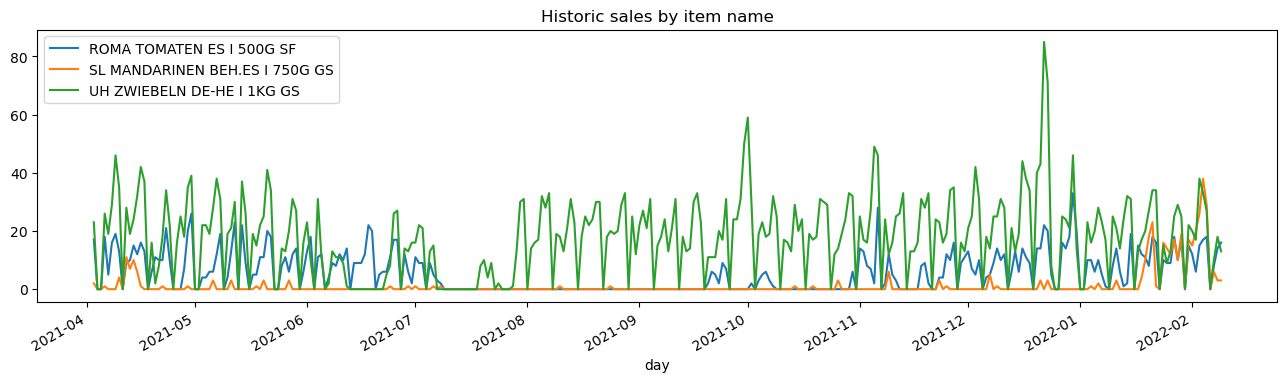

In [8]:
fig, ax = plt.subplots()

for i, g in sales.set_index('day').groupby('item_name'):
    g.plot(y='sales_quantity', ax=ax, label=i)
plt.title('Historic sales by item name')
plt.show()

It seems that, at least onions have a strong short term seasonality across almost the entire year. However, the other two items show a strong decrease in the colder months of the year, probably due to their harvesting seasons. According to [this link](http://na-nu.com/terfloth.org/Kitchen/Season_Cal.pdf) the availability of tangerine is very high on January, February, November and December, and almost not available on the other months, which seems to fit the data. For tomatoe is similar, with high availability from June to November.

Lets look at monthly aggregates

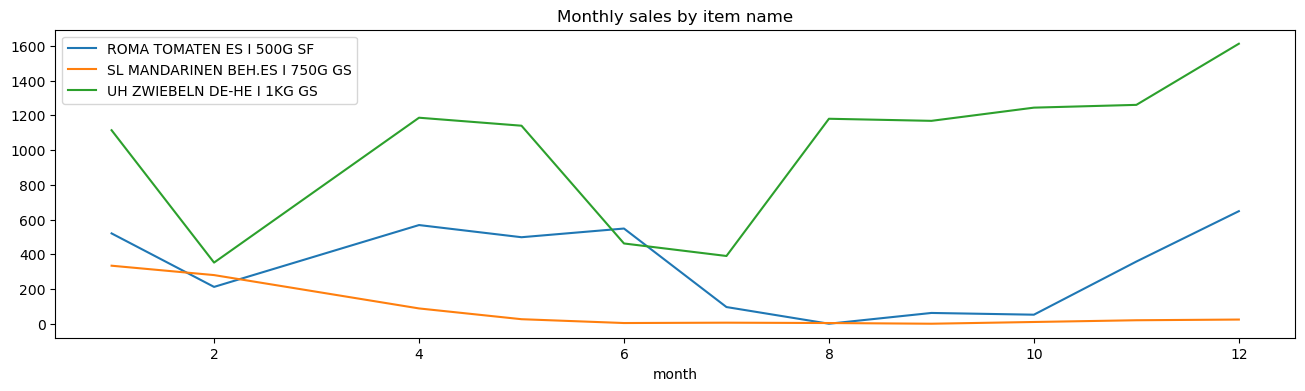

In [18]:
sales_monthly = sales.set_index('day')
sales_monthly['month'] = sales_monthly.index.month
sales_monthly = sales_monthly.groupby(['month', 'item_name'], as_index=False).sales_quantity.sum()

fig, ax = plt.subplots()

for i, g in sales_monthly.set_index('month').groupby('item_name'):
    g.plot(y='sales_quantity', ax=ax, label=i)
plt.title('Monthly sales by item name')
plt.show()

So the explanation for the reduction due to availability looks plausible.

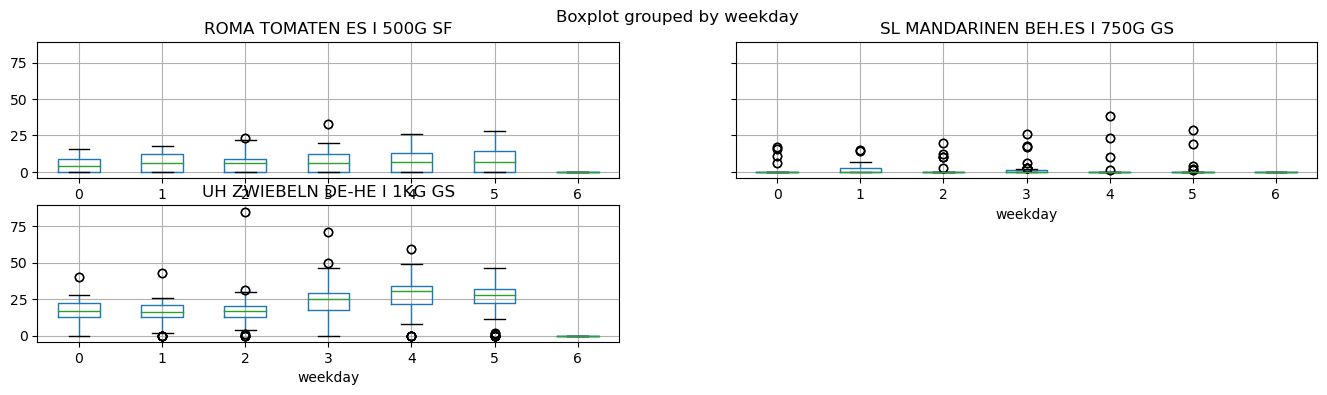

In [22]:
sales['weekday'] = sales.day.dt.weekday

sales.groupby('item_name').boxplot(column='sales_quantity', by='weekday')
plt.show()

# Weekday 0 is Monday

So, from here we see that Onions have a strong weekend seasonality, possibly due to people cooking for their families during the weekends!

# Outliers 

What happened on the days with super high sales?

In [39]:
sales.item_name.unique()

array(['ROMA TOMATEN ES I 500G SF', 'SL MANDARINEN BEH.ES I 750G GS',
       'UH ZWIEBELN DE-HE I 1KG GS'], dtype=object)

In [42]:
onion_sales = sales[sales.item_name=='UH ZWIEBELN DE-HE I 1KG GS']
onion_sales.sort_values('sales_quantity', ascending=False).head(15)

,day,item_number,item_name,purchase_price,suggested_retail_price,orders_quantity,sales_quantity,revenue
298,2021-12-22,80028349,UH ZWIEBELN DE-HE I 1KG GS,0.640000,0.990000,0.0,85.0,84.04
292,2021-12-23,80028349,UH ZWIEBELN DE-HE I 1KG GS,0.640000,0.990000,54.0,71.0,70.06
790,2021-10-01,80028349,UH ZWIEBELN DE-HE I 1KG GS,0.520000,0.660000,36.0,59.0,38.87
796,2021-09-30,80028349,UH ZWIEBELN DE-HE I 1KG GS,0.520000,0.660000,36.0,50.0,32.56
580,2021-11-05,80028349,UH ZWIEBELN DE-HE I 1KG GS,0.590000,0.790000,54.0,49.0,38.40
574,2021-11-06,80028349,UH ZWIEBELN DE-HE I 1KG GS,0.590000,0.790000,0.0,46.0,36.13
250,2021-12-30,80028349,UH ZWIEBELN DE-HE I 1KG GS,0.640000,0.990000,0.0,46.0,45.40
1840,2021-04-09,80028349,UH ZWIEBELN DE-HE I 1KG GS,0.610000,0.790000,0.0,46.0,36.32
334,2021-12-16,80028349,UH ZWIEBELN DE-HE I 1KG GS,0.640000,0.990000,18.0,44.0,43.00
304,2021-12-21,80028349,UH ZWIEBELN DE-HE I 1KG GS,0.640000,0.990000,144.0,43.0,42.51


Okay, so Christmas and new years checks out. Then is this holiday in november, which is probably carnival or something. this tells us that probably we should include some holidays in our models.